# Fourier Space Filtering Based on FRC

Here I investigate how FRC resolution measurement can be combined with frequency domain filtering.

In [1]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image
from supertomo.data.io.write import image as imwrite

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots

from supertomo.processing.fft_filters import fft_filter, butterworth_fft_filter, gaussian_fft_filter



## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. 

In [2]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


In [3]:
from supertomo.ui import deconvolution_options as options
args_list = ("image psf"  
             " --resolution-threshold-criterion=snr --resolution-snr-value=0.25").split()
            
args = options.get_deconvolve_script_options(args_list)

## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20


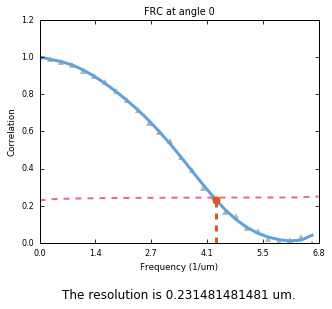

In [4]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

## Low-Pass filtering

In the first filtering alternative I just simply remove all the frequencies beyond the cut-off point. 

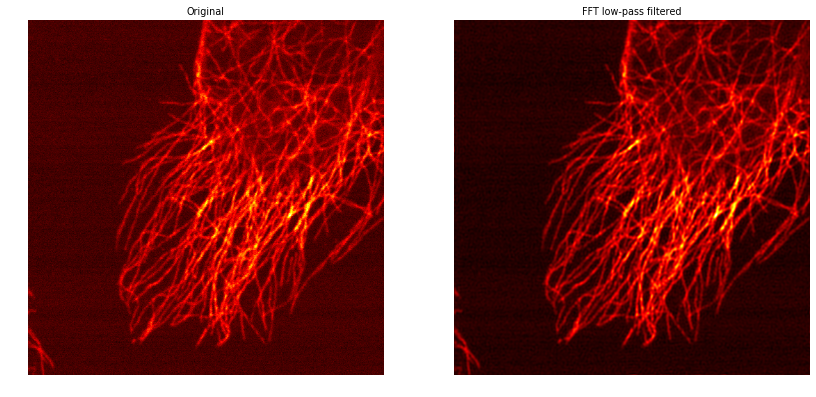

The resolution cut-off point is at 0.44746600997


In [5]:

threshold_point = results[0].resolution['resolution-point'][1]/np.sqrt(2)

ideal_result = fft_filter(image, 
                    threshold_point)

showim.display_2d_images(image, 
                         ideal_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")

print "The resolution cut-off point is at {}".format(threshold_point)

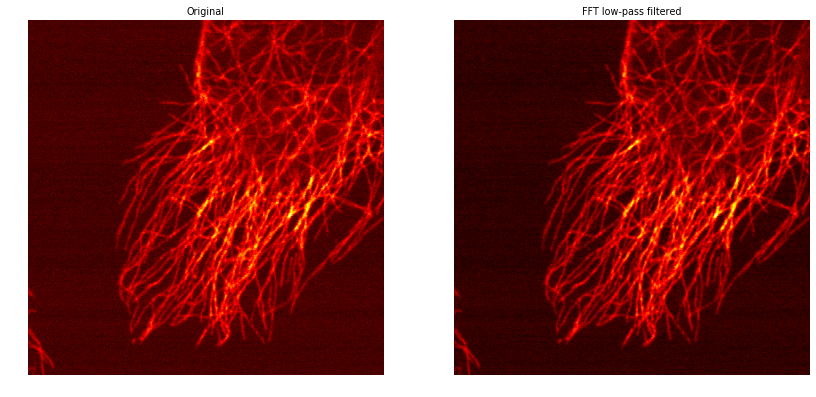

The resolution cut-off point is at 0.44746600997


In [6]:
butterworth_result = butterworth_fft_filter(image, 
                    threshold_point, n=3)

showim.display_2d_images(image, 
                         butterworth_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")

print "The resolution cut-off point is at {}".format(threshold_point)

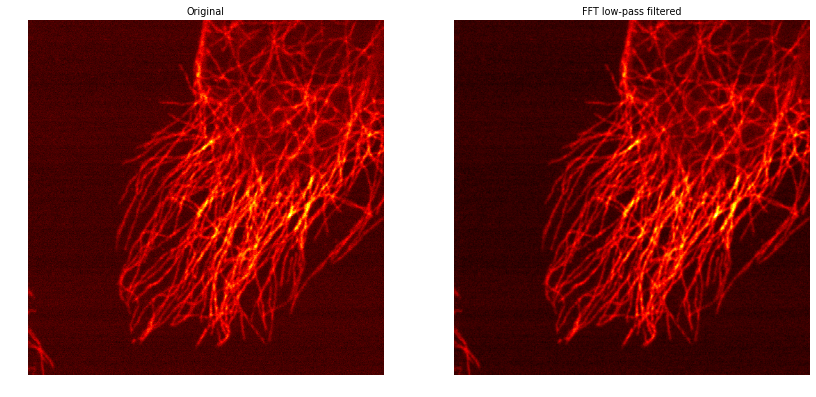

The resolution cut-off point is at 0.44746600997


In [7]:
gaussian_result = gaussian_fft_filter(image, 
                    threshold_point)

showim.display_2d_images(image, 
                         gaussian_result,
                         image1_title="Original",
                         image2_title="FFT low-pass filtered")

print "The resolution cut-off point is at {}".format(threshold_point)

In [12]:
directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_FRC_Deconvolution_Filtering"

imwrite(os.path.join(directory, "original.tif"), Image(image.astype(np.uint16), image.spacing))
imwrite(os.path.join(directory, "ideal_low_pass.tif"), Image(ideal_result.astype(np.uint16), image.spacing))
imwrite(os.path.join(directory, "butterworth_low_pass.tif"), Image(butterworth_result.astype(np.uint16), image.spacing))
imwrite(os.path.join(directory, "gaussian_low_pass.tif"), Image(gaussian_result.astype(np.uint16), image.spacing))

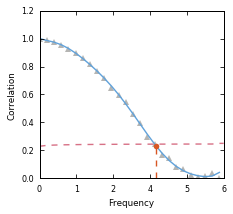

In [15]:
plotter = frcplots.FourierDataPlotter(results, directory)

#plotter.plot_one_to_file(0, "single_image_big")